In [24]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import faiss
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# ResNet50 Embedding Model
class FashionRetrievalModel(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.embedding = nn.Sequential(
            nn.Linear(num_ftrs, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        return F.normalize(self.embedding(features), p=2, dim=1)

# Triplet Dataset
class TripletFashionDataset(Dataset):
    def __init__(self, image_folder, annotation_path, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.annos_folder = "validation/validation/annos"

        print(f"📂 Loading annotations from: {annotation_path}")
        if not os.path.isfile(annotation_path):
            raise FileNotFoundError(f"Annotation file not found: {annotation_path}")

        with open(annotation_path, 'r') as f:
            data = json.load(f)

        self.category_to_images = {}
        for item in data:
            gallery_id = item.get("gallery_image_id")
            pair_id = item.get("pair_id")
            if gallery_id is None or pair_id is None:
                continue
            file_name = f"{gallery_id:06d}.jpg"
            file_path = os.path.join(self.image_folder, file_name)
            if os.path.isfile(file_path):
                self.category_to_images.setdefault(pair_id, []).append(file_name)

        self.image_triplets = self._generate_triplets()
        print(f"✅ Triplets generated: {len(self.image_triplets)}")

        if len(self.image_triplets) == 0:
            raise ValueError("No valid triplets found. Check annotation file and image folder.")

    def _load_and_crop(self, filename):
        img_path = os.path.join(self.image_folder, filename)
        ann_path = os.path.join(self.annos_folder, filename.replace('.jpg', '.json'))

        img = Image.open(img_path).convert("RGB")

        if os.path.isfile(ann_path):
            with open(ann_path, 'r') as f:
                ann = json.load(f)
                if 'bounding_box' in ann:
                    x, y, w, h = ann['bounding_box']
                    img = img.crop((x, y, x + w, y + h))

        return img

    def _generate_triplets(self):
        triplets = []
        categories = list(self.category_to_images.keys())
        for cat in categories:
            imgs = self.category_to_images[cat]
            if len(imgs) < 2:
                continue
            for i in range(len(imgs) - 1):
                anchor = imgs[i]
                positive = imgs[i + 1]
                neg_cat = random.choice([c for c in categories if c != cat and len(self.category_to_images[c]) > 0])
                negative = self.category_to_images[neg_cat][0]
                triplets.append((anchor, positive, negative))
        return triplets

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        a, p, n = self.image_triplets[idx]
        a_img = self._load_and_crop(a)
        p_img = self._load_and_crop(p)
        n_img = self._load_and_crop(n)
        if self.transform:
            a_img = self.transform(a_img)
            p_img = self.transform(p_img)
            n_img = self.transform(n_img)
        return a_img, p_img, n_img

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Training

def train(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (anchor, positive, negative) in enumerate(dataloader):
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            a_embed = model(anchor)
            p_embed = model(positive)
            n_embed = model(negative)

            loss = criterion(a_embed, p_embed, n_embed)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % 10 == 0:
                print(f"Epoch {epoch+1} | Batch {i}/{len(dataloader)} | Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1} complete | Avg Loss: {avg_loss:.4f}")

# Extract Embeddings

def extract_embeddings(model, dataloader):
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for imgs in tqdm(dataloader, desc="Extracting Embeddings"):
            imgs = imgs.to(DEVICE)
            embs = model(imgs).cpu().numpy()
            all_embeddings.append(embs)
    return np.vstack(all_embeddings)

# FAISS Index

def build_faiss_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings.astype(np.float32))
    return index

# Retrieve Similar Images

def retrieve_similar(query_image, model, index, image_paths, transform, k=5):
    model.eval()
    img = Image.open(query_image).convert("RGB")
    img = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        query_embedding = model(img).cpu().numpy()
    D, I = index.search(query_embedding, k)
    return [(image_paths[i], D[0][j]) for j, i in enumerate(I[0])]

# Visualize Results

def visualize_retrieval(query_path, results):
    plt.figure(figsize=(15, 3))
    query_img = Image.open(query_path).convert("RGB")
    plt.subplot(1, len(results) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")
    for i, (path, score) in enumerate(results):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, len(results) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Save and Load Index + Embeddings

def save_faiss_index(index, path):
    faiss.write_index(index, path)

def load_faiss_index(path):
    return faiss.read_index(path)

def save_embeddings(embeddings, image_paths, npy_path, txt_path):
    np.save(npy_path, embeddings)
    with open(txt_path, 'w') as f:
        for p in image_paths:
            f.write(p + '\n')

def load_embeddings(npy_path, txt_path):
    embeddings = np.load(npy_path)
    with open(txt_path, 'r') as f:
        image_paths = [line.strip() for line in f.readlines()]
    return embeddings, image_paths


Using device: cuda


In [11]:
image_folder = "validation/validation/image"
annotation_path = "val_annotations/json_for_validation/val_gallery.json"

# Trigger Dataset + Dataloader
train_dataset = TripletFashionDataset(image_folder, annotation_path, transform)
print("Triplets available:", len(train_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model + Training Setup
model = FashionRetrievalModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.TripletMarginLoss(margin=0.3)

# Train
train(model, train_loader, optimizer, criterion, epochs=5)


📂 Loading annotations from: val_annotations/json_for_validation/val_gallery.json
✅ Triplets generated: 34682
Triplets available: 34682
Epoch 1 | Batch 0/1084 | Loss: 0.0346
Epoch 1 | Batch 10/1084 | Loss: 0.0718
Epoch 1 | Batch 20/1084 | Loss: 0.0390
Epoch 1 | Batch 30/1084 | Loss: 0.0461
Epoch 1 | Batch 40/1084 | Loss: 0.0347
Epoch 1 | Batch 50/1084 | Loss: 0.0128
Epoch 1 | Batch 60/1084 | Loss: 0.0109
Epoch 1 | Batch 70/1084 | Loss: 0.0116
Epoch 1 | Batch 80/1084 | Loss: 0.0533
Epoch 1 | Batch 90/1084 | Loss: 0.0221
Epoch 1 | Batch 100/1084 | Loss: 0.0529
Epoch 1 | Batch 110/1084 | Loss: 0.0252
Epoch 1 | Batch 120/1084 | Loss: 0.0176
Epoch 1 | Batch 130/1084 | Loss: 0.0349
Epoch 1 | Batch 140/1084 | Loss: 0.0135
Epoch 1 | Batch 150/1084 | Loss: 0.0145
Epoch 1 | Batch 160/1084 | Loss: 0.0241
Epoch 1 | Batch 170/1084 | Loss: 0.0245
Epoch 1 | Batch 180/1084 | Loss: 0.0256
Epoch 1 | Batch 190/1084 | Loss: 0.0066
Epoch 1 | Batch 200/1084 | Loss: 0.0000
Epoch 1 | Batch 210/1084 | Loss: 0.0

In [12]:
def get_embedding(model, image_path, transform, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        return model(img).cpu().numpy()

def search(query_embed, index, paths, top_k=5):
    D, I = index.search(query_embed, top_k)
    return [(paths[i], float(D[0][j])) for j, i in enumerate(I[0])]

def build_index_from_folder(model, image_folder, transform, device):
    index = faiss.IndexFlatL2(512)
    image_paths, embeddings = [], []
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        try:
            emb = get_embedding(model, img_path, transform, device)
            index.add(emb)
            image_paths.append(img_path)
        except Exception as e:
            print(f"❌ Failed on {img_path}: {e}")
            continue
    return index, image_paths


In [14]:
def validate_triplet_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for anchor, positive, negative in tqdm(val_loader, desc="Validating"):
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            a_embed = model(anchor)
            p_embed = model(positive)
            n_embed = model(negative)

            pos_dist = F.pairwise_distance(a_embed, p_embed)
            neg_dist = F.pairwise_distance(a_embed, n_embed)

            correct += (pos_dist < neg_dist).sum().item()
            total += anchor.size(0)

    acc = correct / total
    print(f"🧪 Validation Triplet Accuracy: {acc:.4f}")
    return acc


In [25]:
val_dataset = TripletFashionDataset(image_folder, annotation_path, transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

validate_triplet_accuracy(model, val_loader)


📂 Loading annotations from: val_annotations/json_for_validation/val_gallery.json
✅ Triplets generated: 34682


Validating: 100%|██████████| 1084/1084 [18:11<00:00,  1.01s/it]

🧪 Validation Triplet Accuracy: 0.9982


0.9981546623608788

In [26]:
def show_query_and_results(query_path, results):
    plt.figure(figsize=(15, 3))
    query_img = Image.open(query_path).convert("RGB")
    plt.subplot(1, len(results) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    for i, (match_path, dist) in enumerate(results):
        img = Image.open(match_path).convert("RGB")
        plt.subplot(1, len(results) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"{dist:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


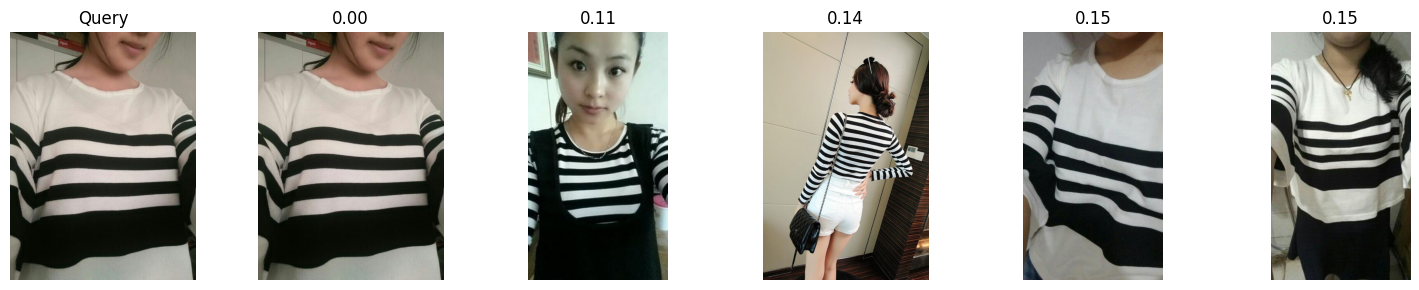

Query: validation/validation/image/000951.jpg
Match: validation/validation/image/000951.jpg (Distance: 0.0000)
Match: validation/validation/image/008870.jpg (Distance: 0.1095)
Match: validation/validation/image/021541.jpg (Distance: 0.1429)
Match: validation/validation/image/000950.jpg (Distance: 0.1458)
Match: validation/validation/image/000946.jpg (Distance: 0.1500)


In [19]:
index, paths = build_index_from_folder(model, "validation/validation/image", transform, DEVICE)
query_embedding = get_embedding(model, paths[0], transform, DEVICE)
results = search(query_embedding, index, paths)
show_query_and_results(paths[0], results)

print("Query:", paths[0])
for match, dist in results:
    print(f"Match: {match} (Distance: {dist:.4f})")


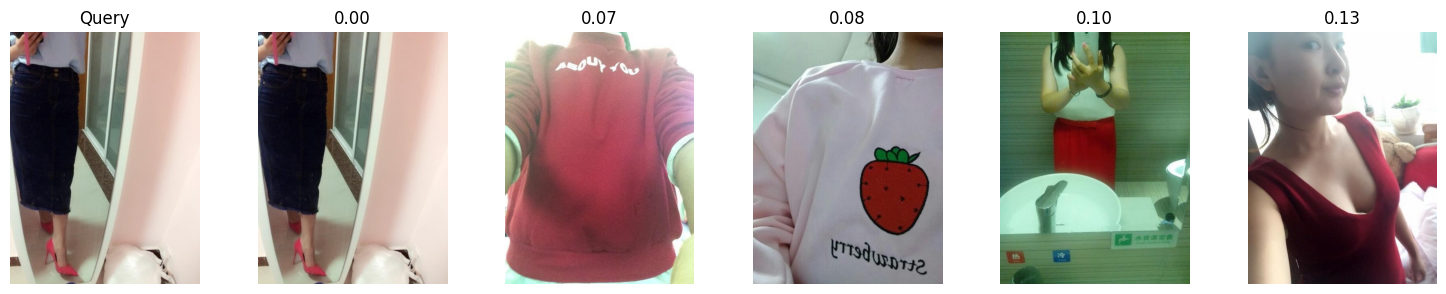

Query: validation/validation/image/000657.jpg
Match: validation/validation/image/000657.jpg (Distance: 0.0000)
Match: validation/validation/image/009765.jpg (Distance: 0.0739)
Match: validation/validation/image/001201.jpg (Distance: 0.0832)
Match: validation/validation/image/010079.jpg (Distance: 0.0978)
Match: validation/validation/image/007265.jpg (Distance: 0.1337)


In [27]:
index, paths = build_index_from_folder(model, "validation/validation/image", transform, DEVICE)
query_embedding = get_embedding(model, paths[10], transform, DEVICE)
results = search(query_embedding, index, paths)
show_query_and_results(paths[10], results)

print("Query:", paths[10])
for match, dist in results:
    print(f"Match: {match} (Distance: {dist:.4f})")


In [31]:

# Retrieve Similar Images with Classification Info

def retrieve_similar_with_classification(query_image, model, index, image_paths, transform, k=5):
    model.eval()
    img = Image.open(query_image).convert("RGB")
    img = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        query_embedding = model(img).cpu().numpy()
    D, I = index.search(query_embedding, k)
    results = [(image_paths[i], D[0][j]) for j, i in enumerate(I[0])]

    # Attempt to print classification from alternate json sources
    print("\n📊 Classification of retrieved results:")
    with open("retrieval_val_consumer_information.json", "r") as f:
        consumer_data = json.load(f)
        consumer_lookup = {img["file_name"]: img for img in consumer_data.get("images", [])}

    for path, dist in results:
        fname = os.path.basename(path)
        metadata = consumer_lookup.get(fname)
        if metadata:
            print(f"Image: {fname} | Dist: {dist:.4f} | Metadata: {json.dumps(metadata)}")
        else:
            print(f"Image: {fname} | Dist: {dist:.4f} | Metadata: Not found")

    return results

# You can use this function in place of retrieve_similar:
# results = retrieve_similar_with_classification(query_path, model, index, image_paths, transform, k=5)
# visualize_retrieval(query_path, results)


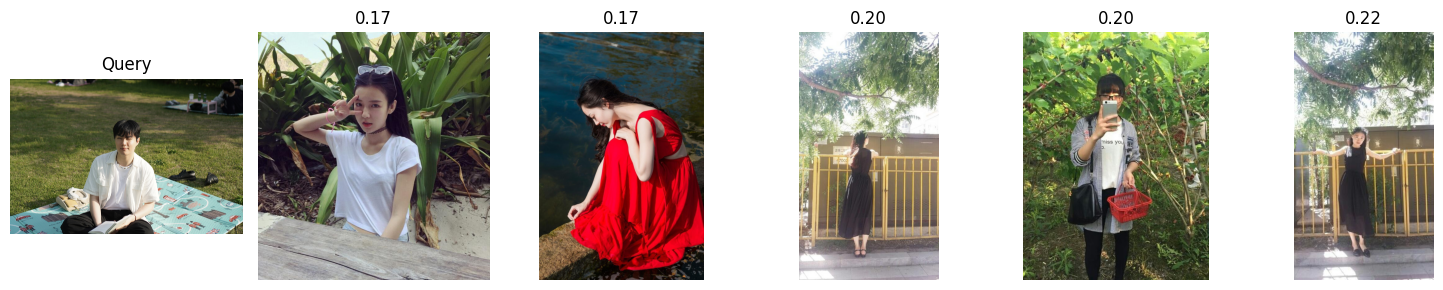

In [30]:
query_path = "TestImage.jpg"
query_embedding = get_embedding(model, query_path, transform, DEVICE)
results = search(query_embedding, index, paths)
show_query_and_results(query_path, results)
